In [1]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128
                                                    , shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(testset,batch_size=128
                                                     , shuffle=True, num_workers=8)


100%|██████████| 170498071/170498071 [00:03<00:00, 55370345.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


  Densenet-BC model class, based on
  Densely Connected Convolutional Networks <https://arxiv.org/pdf/1608.06993.pdf>


In [4]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate) :
        super(_DenseLayer,self).__init__()
        self.denselayers = nn.Sequential(
            OrderedDict(
                [   ("norm1", nn.BatchNorm2d(num_input_features)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("conv1", nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
                    ("norm2", nn.BatchNorm2d(bn_size * growth_rate)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("conv2", nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
                ]
            )
        )
        self.drop_rate=drop_rate


    def forward(self, input):
        concated_features = torch.cat(input, 1)
        new_features = self.denselayers(concated_features)
        new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):

    def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module("dl%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition,self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):

    def __init__(self,growth_rate= 32,block_config=[6, 12, 24, 16],num_init_features= 64,bn_size= 4,drop_rate = 0,num_classes = 1000):

        super(DenseNet,self).__init__()

        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module("db%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        
        features = self.features(x)
        out = F.relu(features, inplace=True)
        
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        out = F.softmax(out,dim=1)
        return out




In [5]:
def train_model(optimizer,trainloader,testloader,criterion,model,epochs):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.to(device)
            output = model(data)
            loss = criterion(output,target)
            indices=torch.max(torch.exp(output),1)[1]
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(indices.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)
    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.to(device)
              output = model(data)
              indices=torch.max(output,1)[1]
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(indices.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]
    test_loss=[]
    train_acc=[]
    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("train_acc",tr_acc)
        print("test_acc",ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')
  ax.legend()
  plt.show()

In [6]:
dense_net=DenseNet(block_config=[6,12,24,16],growth_rate=12,num_classes=len(torch.unique(all_train_labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
criterion = nn.CrossEntropyLoss()
dense_net = dense_net.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(dense_net.parameters(), lr=0.0001)
Loss,accuracy=train_model(optimizer,train_loader,test_loader,criterion,dense_net,EPOCH)


  2%|▏         | 1/50 [00:43<35:11, 43.09s/it]

train_acc 0.38254
test_acc 0.4714


  4%|▍         | 2/50 [01:19<31:16, 39.09s/it]

train_acc 0.51492
test_acc 0.5243


  6%|▌         | 3/50 [01:57<30:09, 38.51s/it]

train_acc 0.56262
test_acc 0.5515


  8%|▊         | 4/50 [02:34<29:06, 37.97s/it]

train_acc 0.59312
test_acc 0.5661


 10%|█         | 5/50 [03:11<28:14, 37.66s/it]

train_acc 0.6144
test_acc 0.5731


 12%|█▏        | 6/50 [03:48<27:28, 37.46s/it]

train_acc 0.63468
test_acc 0.5878


 14%|█▍        | 7/50 [04:25<26:41, 37.24s/it]

train_acc 0.65084
test_acc 0.5851


 16%|█▌        | 8/50 [05:01<25:54, 37.02s/it]

train_acc 0.6656
test_acc 0.5953


 18%|█▊        | 9/50 [05:39<25:22, 37.14s/it]

train_acc 0.6773
test_acc 0.6098


 20%|██        | 10/50 [06:16<24:42, 37.07s/it]

train_acc 0.6871
test_acc 0.6037


 22%|██▏       | 11/50 [06:53<24:07, 37.12s/it]

train_acc 0.6992
test_acc 0.6113


 24%|██▍       | 12/50 [07:30<23:25, 36.99s/it]

train_acc 0.70832
test_acc 0.6192


 26%|██▌       | 13/50 [08:07<22:50, 37.05s/it]

train_acc 0.72072
test_acc 0.6198


 28%|██▊       | 14/50 [08:43<22:09, 36.94s/it]

train_acc 0.72512
test_acc 0.6245


 30%|███       | 15/50 [09:20<21:30, 36.88s/it]

train_acc 0.73432
test_acc 0.6172


 32%|███▏      | 16/50 [09:57<20:57, 36.97s/it]

train_acc 0.74148
test_acc 0.626


 34%|███▍      | 17/50 [10:34<20:20, 36.98s/it]

train_acc 0.74834
test_acc 0.6373


 36%|███▌      | 18/50 [11:12<19:44, 37.03s/it]

train_acc 0.75678
test_acc 0.6347


 38%|███▊      | 19/50 [11:49<19:08, 37.05s/it]

train_acc 0.76108
test_acc 0.6363


 40%|████      | 20/50 [12:26<18:29, 37.00s/it]

train_acc 0.76694
test_acc 0.6408


 42%|████▏     | 21/50 [13:01<17:41, 36.59s/it]

train_acc 0.77236
test_acc 0.6169


 44%|████▍     | 22/50 [13:38<17:07, 36.71s/it]

train_acc 0.77856
test_acc 0.6476


 46%|████▌     | 23/50 [14:15<16:32, 36.75s/it]

train_acc 0.78238
test_acc 0.6437


 48%|████▊     | 24/50 [14:52<15:58, 36.87s/it]

train_acc 0.78938
test_acc 0.6467


 50%|█████     | 25/50 [15:29<15:22, 36.89s/it]

train_acc 0.79246
test_acc 0.6435


 52%|█████▏    | 26/50 [16:06<14:46, 36.94s/it]

train_acc 0.79366
test_acc 0.6424


 54%|█████▍    | 27/50 [16:44<14:15, 37.19s/it]

train_acc 0.80066
test_acc 0.6404


 56%|█████▌    | 28/50 [17:21<13:38, 37.22s/it]

train_acc 0.80314
test_acc 0.6498


 58%|█████▊    | 29/50 [17:58<12:57, 37.03s/it]

train_acc 0.8029
test_acc 0.6454


 60%|██████    | 30/50 [18:35<12:21, 37.08s/it]

train_acc 0.80936
test_acc 0.651


 62%|██████▏   | 31/50 [19:12<11:43, 37.03s/it]

train_acc 0.81366
test_acc 0.6531


 64%|██████▍   | 32/50 [19:49<11:06, 37.04s/it]

train_acc 0.81832
test_acc 0.653


 66%|██████▌   | 33/50 [20:26<10:30, 37.09s/it]

train_acc 0.82322
test_acc 0.6656


 68%|██████▊   | 34/50 [21:03<09:52, 37.04s/it]

train_acc 0.8293
test_acc 0.6448


 70%|███████   | 35/50 [21:40<09:12, 36.86s/it]

train_acc 0.8297
test_acc 0.6537


 72%|███████▏  | 36/50 [22:17<08:37, 36.93s/it]

train_acc 0.8334
test_acc 0.6568


 74%|███████▍  | 37/50 [22:54<08:00, 36.99s/it]

train_acc 0.83488
test_acc 0.6512


 76%|███████▌  | 38/50 [23:31<07:24, 37.06s/it]

train_acc 0.83556
test_acc 0.6533


 78%|███████▊  | 39/50 [24:08<06:48, 37.14s/it]

train_acc 0.83888
test_acc 0.656


 80%|████████  | 40/50 [24:46<06:11, 37.18s/it]

train_acc 0.84016
test_acc 0.6507


 82%|████████▏ | 41/50 [25:23<05:35, 37.26s/it]

train_acc 0.84278
test_acc 0.6615


 84%|████████▍ | 42/50 [26:00<04:58, 37.31s/it]

train_acc 0.84506
test_acc 0.6579


 86%|████████▌ | 43/50 [26:37<04:19, 37.07s/it]

train_acc 0.8474
test_acc 0.6606


 88%|████████▊ | 44/50 [27:16<03:45, 37.51s/it]

train_acc 0.84778
test_acc 0.6645


 90%|█████████ | 45/50 [27:54<03:08, 37.78s/it]

train_acc 0.85342
test_acc 0.6648


 92%|█████████▏| 46/50 [28:31<02:30, 37.64s/it]

train_acc 0.85568
test_acc 0.6579


 94%|█████████▍| 47/50 [29:08<01:52, 37.49s/it]

train_acc 0.85798
test_acc 0.6561


 96%|█████████▌| 48/50 [29:45<01:14, 37.37s/it]

train_acc 0.85736
test_acc 0.6605


 98%|█████████▊| 49/50 [30:23<00:37, 37.32s/it]

train_acc 0.85872
test_acc 0.6625


100%|██████████| 50/50 [31:00<00:00, 37.22s/it]

train_acc 0.8615
test_acc 0.6632


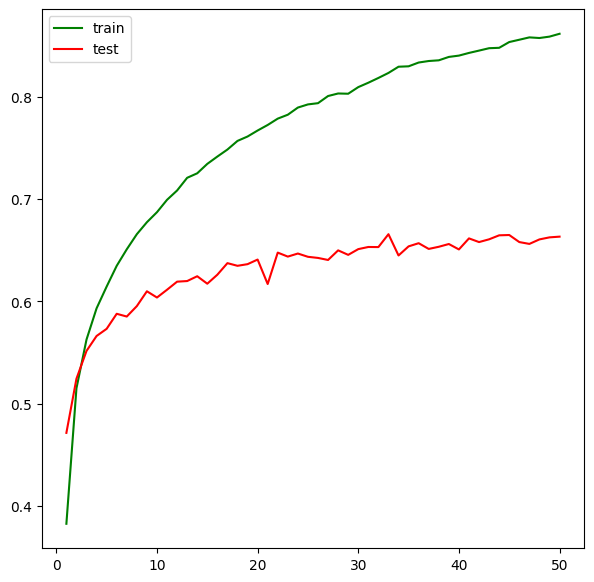

In [7]:
plot(accuracy,EPOCH)

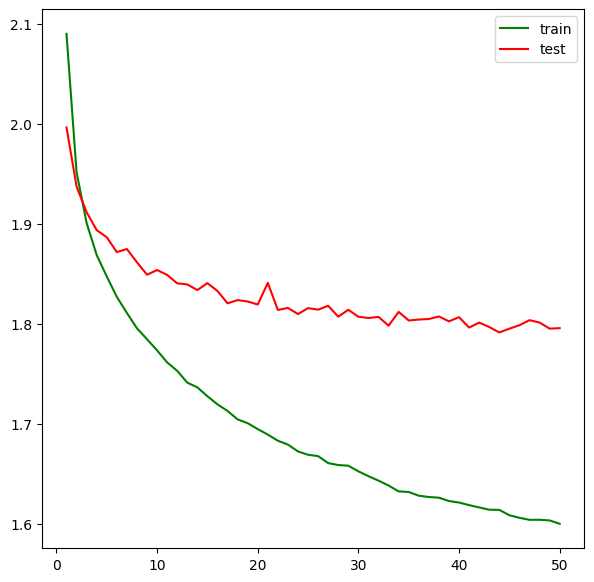

In [8]:
plot(Loss,EPOCH)

In [9]:
torch.save(dense_net,"densenet_121_cifar_10.pt")